# This notebook produces cluster star results

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import stardate as sd

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

To do: 

git rid of the gyro_only option

Convert the dictionary into the param_dict thing

So the user just has to provide the observables and, if they want, alll the other choices are made for them. 
They get posterior samples back.

Load the Praesepe data.

In [8]:
df = pd.read_csv("../data/praesepe_no_outliers.csv")
df.keys()

Index(['Unnamed: 0', 'praesepe_oid', 'col1', 'solution_id', 'designation',
       'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec',
       ...
       '_RA', '_DE', 'period', 'id_y', 'jmag', 'e_jmag', 'hmag', 'e_hmag',
       'kmag', 'e_kmag'],
      dtype='object', length=145)

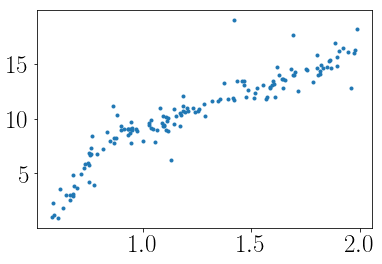

In [9]:
plt.plot(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.Prot1, ".")

In [10]:
# obs = pd.DataFrame(dict({"G": df.phot_g_mean_mag, "G_err": df.phot_g_mean_mag*.01,
#                          "bp": df.phot_bp_mean_mag, "bp_err": df.phot_bp_mean_mag*.01,
#                          "rp": df.phot_rp_mean_mag, "rp_err": df.phot_rp_mean_mag*.01,
#                          "Kepler": df.Kpmag, "Kepler_err": df.Kpmag*.01,
#                          "parallax": df.parallax, "parallax_err": df.parallax_error}))

In [11]:
savedir = "cluster_results/iso_and_gyro"
savedir_iso = "cluster_results/iso_only"

prot, prot_err = df.Prot1, df.Prot1*.1

N = len(df)
for i in range(N):
    print(i, "of", N)
    
    iso_params = {"G": (df.phot_g_mean_mag[i], df.phot_g_mean_mag[i]*.01),
                  "bp": (df.phot_bp_mean_mag[i], df.phot_bp_mean_mag[i]*.01),
                  "rp": (df.phot_rp_mean_mag[i], df.phot_rp_mean_mag[i]*.01),
                  "J": (df.jmag[i], df.e_jmag[i]),
                  "H": (df.hmag[i], df.e_hmag[i]),
                  "K": (df.kmag[i], df.e_kmag[i]),
                  "maxAV": .1,
                  "parallax": (df.parallax[i], df.parallax_error[i])} 
    
    # Isochrone fitting and gyrochronology
    star = sd.star(iso_params, prot[i], prot*.05, savedir=savedir, suffix=i)
    sampler = star.fit()
    truths = [None, np.log10(650e6), .11, None, None]
    star.make_plots(truths, burnin=10000)
    
    # Isochrones only
    star = sd.star(iso_params, prot[i], prot*.05, savedir=iso_savedir, suffix=i)
    sampler = star.fit(iso_only=True)
    truths = [None, np.log10(650e6), .11, None, None]
    star.make_plots(truths, burnin=10000)

0 of 149


TypeError: float() argument must be a string or a number, not 'tuple'